In [4]:
#import eumdac
from datetime import timedelta as td
from datetime import datetime as dt
import shutil
import os
import numpy as np
#import iris
#import iris.coords
#import iris.cube
#import iris.plot as iplt
from satpy import Scene
from satpy.writers import get_enhanced_image
from pyresample import get_area_def
# import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# MSG0 data started 2004

# Original list based on Sue's paper + some recents
# cases = {
#     'greatstorm':   {'date': dt(1987, 10, 16,  1, 30), 'lon': -5, 'lat': 50},
#     'oratia':       {'date': dt(2000, 10, 30,  8, 30), 'lon': -5, 'lat': 50},
#     'anna':         {'date': dt(2002,  2, 26,  5,  0), 'lon': -15, 'lat': 58},
#     'jeanette':     {'date': dt(2002, 10, 26,  0,  0), 'lon': -15, 'lat': 54},
#     'gudron':       {'date': dt(2005,  1,  8,  8,  0), 'lon': -5, 'lat': 50},
#     'friedhelm':    {'date': dt(2011, 12,  8, 12,  0), 'lon': -10, 'lat': 57},
#     'ulli':         {'date': dt(2012,  1,  3,  4,  0), 'lon': -5, 'lat': 50},
#     'stjudestorm' : {'date': dt(2013, 10, 28,  9,  0), 'lon': -5, 'lat': 50},
#     'tini' :        {'date': dt(2014,  2, 12,  6,  0), 'lon': -15, 'lat': 50},
#     'tini2' :       {'date': dt(2014,  2, 12, 12,  0), 'lon':  -7, 'lat': 52},
#     'ophelia':      {'date': dt(2017, 10, 16, 10,  0), 'lon': -10, 'lat': 52},
#     'brendan' :     {'date': dt(2020,  1, 13, 12,  0), 'lon': -15, 'lat': 55},
#     'alex' :        {'date': dt(2020, 10,  2, 12,  0), 'lon': -5, 'lat': 50},
#     'eunice' :      {'date': dt(2022,  2, 18,  6,  0), 'lon': -5, 'lat': 52},
#     'shtest':       {'date': dt(2013, 10, 28, 12,  0), 'lon': -40, 'lat': -50},
# }

# List for Ambrogio's mesoscale ppt
cases = {
    'eunice' :        {'date': dt(2022,  2, 18,  6,  0), 'lon': -5, 'lat': 52},
    'greatstorm':     {'date': dt(1987, 10, 16,  0,  0), 'lon': -5, 'lat': 52},
    'burnsday' :      {'date': dt(1990,  1, 25, 12,  0), 'lon': -5, 'lat': 52},
    'lothar' :        {'date': dt(1999, 12, 26,  0,  0), 'lon': -5, 'lat': 47},
    'martin' :        {'date': dt(1999, 12, 27, 18,  0), 'lon': -5, 'lat': 47},
    'kyrill' :        {'date': dt(2007,  1, 18,  0,  0), 'lon': -25, 'lat': 52},
    'friedhelm' :     {'date': dt(2011, 12,  8, 12,  0), 'lon': -5, 'lat': 57},
    'stjude':         {'date': dt(2013, 10, 28, 12,  0), 'lon': 10, 'lat': 55},
    'tini' :          {'date': dt(2014,  2, 12, 12,  0), 'lon': -5, 'lat': 52},
    'ophelia':        {'date': dt(2017, 10, 16,  6,  0), 'lon': -10, 'lat': 50},
    'alaskan' :       {'date': dt(2018, 12,  7, 18,  0), 'lon': -145, 'lat': 52},
    'shbomb' :        {'date': dt(2021,  8, 13,  0,  0), 'lon': -10, 'lat': -68},
}

ddir = r'C:\Users\sw825517\OneDrive - University of Reading\research\code\eumetsat'


def get_images(dt):

    consumer_key = '9Kplg3cMsnqL3Uzo_aZrhUqwOu8a'
    consumer_secret = 'Hf9qKiMD3UWKOoMV2_uku0fdHv8a'
    credentials = (consumer_key, consumer_secret)
    token = eumdac.AccessToken(credentials)

    datastore = eumdac.DataStore(token)
    selected_collection = datastore.get_collection('EO:EUM:DAT:MSG:HRSEVIRI')

    # Set sensing start and end time
    start = dt
    end = dt + td(minutes=15)

    # Retrieve datasets that match our filter
    print(f'Searching for images in {start} to {end}')
    products = selected_collection.search(dtstart=start, dtend=end)
    for product in products: print(product)
    for product in products:
        print(f'\nRetrieving {product}')
        with product.open() as fsrc:
            with open(fsrc.name, mode='wb') as fdst:
                shutil.copyfileobj(fsrc, fdst)
            print(f'Unpacking {fdst.name}')
            shutil.unpack_archive(fdst.name, extract_dir=ddir + '/data/' + fdst.name)
            print(f'Removing {fdst.name}')
            os.remove(fdst.name)
        print('Download of product {product} finished.')
        return fdst

def plot_image(fdst, lon, lat, name):
    print(f'Loading {fdst}')
    scn = Scene(reader='seviri_l1b_native', filenames=[fdst])
    scn.load([name])
    dt = scn[name].attrs['start_time']
    dtstr1 = dt.strftime('%H:%MZ %d %b %Y')
    dtstr2 = dt.strftime('%Y%m%d_%H%MZ')

    # Reproject to PlateCarree projection
    pc = ccrs.PlateCarree()
    dlon = 10
    dlat = 10
    a=get_area_def(1, 'casename', 'PlateCarree', pc.proj4_params, 1000, 1000,
                   [lon-dlon, lat-dlat, lon+dlon, lat+dlat])
    scn2 = scn.resample(a)

    # # Reproject to LambertConformal - plotting via iris not working yet...
    # pc = ccrs.LambertConformal(lon, lat, cutoff=0)
    # dlon = 10
    # dlat = 6
    # a=get_area_def(1, casename, 'LambertConformal',
    #                pc.proj4_params, 1000, 1000,
    #                [*pc.transform_point(lon - dlon, lat - dlat,
    #                                     ccrs.PlateCarree()),
    #                 *pc.transform_point(lon + dlon, lat + dlat,
    #                                     ccrs.PlateCarree())])
    # scn2 = scn.resample(a)

    crs = a.to_cartopy_crs()
    fig, ax = plt.subplots(1, 1, figsize=[12, 8],
                            subplot_kw={'projection': crs})

    # Use plt.imshow to plot RGB fields
    # (allows use of RGB fields but needs axes set up with correct projection)
    img = get_enhanced_image(scn2[name]).data.transpose('y', 'x', 'bands')
    ax.imshow(img, transform=crs, extent=crs.bounds, origin='upper', cmap='Greys')
    ax.coastlines()
    ax.gridlines()
    ax.set_title(name, loc='left')
    ax.set_title(dtstr1, loc='right')

    # # Use plt.imshow to plot mono fields
    # for name, ax in zip(names_mono, axs.flatten()[len(names_rgb):]):
    #     img = get_enhanced_image(scn2[name]).data.transpose('y', 'x', 'bands')
    #     ax.imshow(img, transform=crs, extent=crs.bounds, origin='upper', cmap='Greys')
    #     ax.coastlines()
    #     ax.gridlines()
    #     ax.set_title(name, loc='left')
    #     ax.set_title(dtstr1, loc='right')

    fig.tight_layout()
    fig.show()
    # fn = f'{ddir}/figs/{casename}_{dtstr2}.png'
    # print(f'Saving image {fn}')
    # fig.savefig(fn)


def main(casename='eunice'):
    fdst = f'{ddir}/data/{fdst0.name[:-4]}.nat'
    plot_image(fdst, case['lon'], case['lat'], casename)

ModuleNotFoundError: No module named 'matplotlib'

In [2]:
file = 'data/MSG4-SEVI-MSG15-0100-NA-20230130161243.581000000Z-NA/MSG4-SEVI-MSG15-0100-NA-20230130161243.581000000Z-NA.nat'
plot_image(file, -3, 54, 'IR_039')

NameError: name 'plot_image' is not defined

In [52]:
get_images(cases['eunice']['date'])

Searching for images in 2022-02-18 06:00:00 to 2022-02-18 06:15:00
MSG4-SEVI-MSG15-0100-NA-20220218061242.185000000Z-NA

Retrieving MSG4-SEVI-MSG15-0100-NA-20220218061242.185000000Z-NA
Unpacking MSG4-SEVI-MSG15-0100-NA-20220218061242.185000000Z-NA.zip
Removing MSG4-SEVI-MSG15-0100-NA-20220218061242.185000000Z-NA.zip
Download of product {product} finished.


<_io.BufferedWriter name='MSG4-SEVI-MSG15-0100-NA-20220218061242.185000000Z-NA.zip'>

In [3]:
def plot_image(fdst, lon, lat, casename):
    print(f'Loading {fdst}')
    scn = Scene(reader='seviri_l1b_native', filenames=[fdst])
    names_rgb = ['natural_color', 'ir_overview']
    names_mono = ['WV_073', 'VIS006', 'IR_039', 'IR_108']
    scn.load(names_rgb + names_mono)
    dt = scn[names_rgb[0]].attrs['start_time']
    dtstr1 = dt.strftime('%H:%MZ %d %b %Y')
    dtstr2 = dt.strftime('%Y%m%d_%H%MZ')

    # Reproject to PlateCarree projection
    pc = ccrs.PlateCarree()
    dlon = 15
    dlat = 10
    a=get_area_def(1, casename, 'PlateCarree', pc.proj4_params, 1000, 1000,
                   [lon-dlon, lat-dlat, lon+dlon, lat+dlat])
    scn2 = scn.resample(a)

    # # Reproject to LambertConformal - plotting via iris not working yet...
    # pc = ccrs.LambertConformal(lon, lat, cutoff=0)
    # dlon = 10
    # dlat = 6
    # a=get_area_def(1, casename, 'LambertConformal',
    #                pc.proj4_params, 1000, 1000,
    #                [*pc.transform_point(lon - dlon, lat - dlat,
    #                                     ccrs.PlateCarree()),
    #                 *pc.transform_point(lon + dlon, lat + dlat,
    #                                     ccrs.PlateCarree())])
    # scn2 = scn.resample(a)

    crs = a.to_cartopy_crs()
    fig, axs = plt.subplots(2, 3, figsize=[12, 8],
                            subplot_kw={'projection': crs})

    # Use plt.imshow to plot RGB fields
    # (allows use of RGB fields but needs axes set up with correct projection)
    for name, ax in zip(names_rgb, axs.flatten()[:len(names_rgb)]):
        img = get_enhanced_image(scn2[name]).data.transpose('y', 'x', 'bands')
        ax.imshow(img, transform=crs, extent=crs.bounds, origin='upper')
        ax.coastlines()
        ax.gridlines()
        ax.set_title(name, loc='left')
        ax.set_title(dtstr1, loc='right')

    # # Use plt.imshow to plot mono fields
    # for name, ax in zip(names_mono, axs.flatten()[len(names_rgb):]):
    #     img = get_enhanced_image(scn2[name]).data.transpose('y', 'x', 'bands')
    #     ax.imshow(img, transform=crs, extent=crs.bounds, origin='upper', cmap='Greys')
    #     ax.coastlines()
    #     ax.gridlines()
    #     ax.set_title(name, loc='left')
    #     ax.set_title(dtstr1, loc='right')

    # Put in an iris cube and plot
    for name, ax in zip(names_mono, axs.flatten()[len(names_rgb):]):
        # For PlateCarree - works ok
        xc = iris.coords.DimCoord(scn2[name].x, standard_name='longitude')
        yc = iris.coords.DimCoord(scn2[name].y, standard_name='latitude')
        # For LambertConformal - not working. Need to define coord_system?
        # xc = iris.coords.DimCoord(scn2[name].x, standard_name='projection_x_coordinate',
        #                           coord_system=crs.coordinate_system)
        # yc = iris.coords.DimCoord(scn2[name].y, standard_name='projection_y_coordinate',
        #                           coord_system=crs.coordinate_system)
        img = get_enhanced_image(scn2[name]).data.squeeze()
        cube = iris.cube.Cube(img, dim_coords_and_dims=[(xc, 1), (yc, 0)])
        iplt.pcolormesh(cube, cmap='Greys', axes=ax)
        ax.coastlines()
        ax.gridlines()
        ax.set_title(name, loc='left')
        ax.set_title(dtstr1, loc='right')

    fig.tight_layout()
    fig.show()
    # fn = f'{ddir}/figs/{casename}_{dtstr2}.png'
    # print(f'Saving image {fn}')
    # fig.savefig(fn)


def main(casename='eunice'):
    case = cases[casename]
    fdst0 = get_images(case['date'])
    if fdst0:
        fdst = f'{ddir}/data/{fdst0.name[:-4]}.nat'
        plot_image(fdst, case['lon'], case['lat'], casename)

Loading data/MSG4-SEVI-MSG15-0100-NA-20220218061242.185000000Z-NA.zip/MSG4-SEVI-MSG15-0100-NA-20220218061242.185000000Z-NA.nat


C:\Users\sw825517\Documents\miniconda3\envs\sattest\lib\site-packages\dask\core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\sw825517\Documents\miniconda3\envs\sattest\lib\site-packages\iris\coords.py:2047: UserWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  warnings.warn(
C:\Users\sw825517\Documents\miniconda3\envs\sattest\lib\site-packages\iris\coords.py:2047: UserWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  warnings.warn(
C:\Users\sw825517\Documents\miniconda3\envs\sattest\lib\site-packages\pyproj\crs\crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
C:\Users\sw825517\Documents\miniconda3\envs\sattest\lib\site-packages

Saving image C:\Users\sw825517\OneDrive - University of Reading\research\code\eumetsat/figs/henk_20220218_0600Z.png


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\sw825517\\OneDrive - University of Reading\\research\\code\\eumetsat/figs/henk_20220218_0600Z.png'

C:\Users\sw825517\Documents\miniconda3\envs\sattest\lib\site-packages\matplotlib\cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)
C:\Users\sw825517\Documents\miniconda3\envs\sattest\lib\site-packages\matplotlib\cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)
C:\Users\sw825517\Documents\miniconda3\envs\sattest\lib\site-packages\matplotlib\cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)
C:\Users\sw825517\Documents\miniconda3\envs\sattest\lib\site-packages\matplotlib\cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)
C:\Users\sw825517\Documents\miniconda3\envs\sattest\lib\site-packages\matplotlib\cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)
C:\Users\sw825517\Documents\miniconda3\envs\sattest\lib\site-packages\matplotlib\cm.py:478: RuntimeWarning: invalid

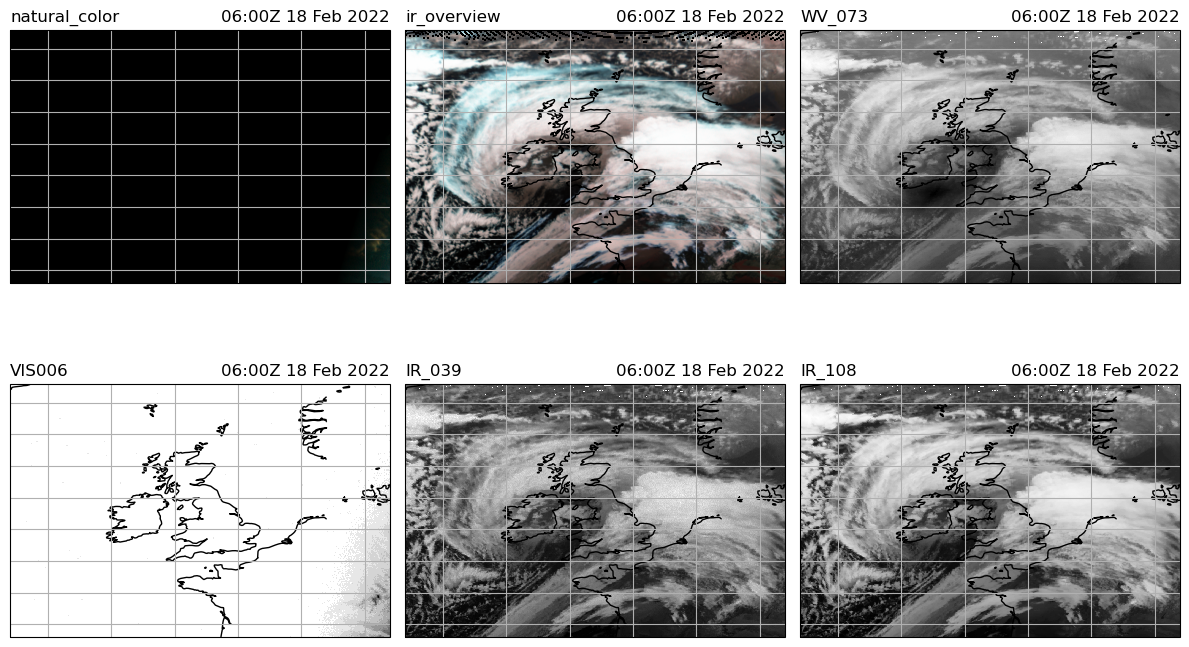

In [6]:
file = 'data/MSG4-SEVI-MSG15-0100-NA-20220218061242.185000000Z-NA.zip/MSG4-SEVI-MSG15-0100-NA-20220218061242.185000000Z-NA.nat'
plot_image(file, -3, 54, 'henk')